Plot Fig. 3c,d

In [1]:
import sys
import os
import argparse
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.patches import Circle

from DATA.MetUM_variables import VARDIC
from config import *
from CP4.utils.make_colorbar import MidpointNormalize
from CP4.make_composites.SM_contrast.b1_make_var_field_anomaly_contrast import load_contrast_composite_mean_ano_field
from CP4.make_composites.SM_contrast.significance.b_compute_var_field_significance_contrast_merge import load_contrast_composite_significance_pvalues_merge
from CP4.plots.p_config import *

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [2]:
coords = [[(10., 18.), (-20., -10.)], [(10.,18.), (-14., -4.)], [(10.,18.), (-8., 2.)], [(10.,18.), (-2.,8.)], [(8.,16.), (8.,18.)]]

In [10]:
ds='CP4A'
res=4
var_ref='twb'
var='twb'
window=6
y0=1997
y1=2006
months=[5, 6, 7, 8, 9]
q_thresh=0.95
t_thresh=26.
min_hw_size=100.   # km2
max_hw_size=1000000.   # km2
sw=[4., 4.]
tw=[-72, 72]
n_days=3
meth='cc3d'
cnty=26
samtime=[19, 19]
length=25  # km
pvalue=0.01  # km
size='small'
size_length=25
flabel='c'

In [8]:
years = np.arange(y0, y1+1, 1)
years_ = str(y0) + '-' + str(y1)
months_ = "-".join([str(m) for m in months])

res_ = str(res) + 'km'

swlat = sw[0]
swlon = sw[1]
sw_ = str(swlat) + 'x' + str(swlon)

space_scale = str(min_hw_size) + '-' + str(max_hw_size)
space_scale_ = str(int(min_hw_size)) + '-' + str(int(max_hw_size))

tw_before = tw[0]
tw_after = tw[1]
assert tw_before <= tw_after, "Incorrect number of time steps"
tw_ = str(tw_before) + '_to_' + str(tw_after)

if var == 'twb':
    unit = '$^\circ$C'
elif (var == 'sh') or (var == 'lh'):
    unit = 'W m$^{-2}$'
else:
    unit = VARDIC[var][3]

var_ = var_names[var]

In [11]:
#~ Get data

pvalues = load_contrast_composite_significance_pvalues_merge(ds, res, var_ref, var, y0, y1, months, t_thresh, q_thresh, n_days, meth, cnty, window, sw, tw, samtime, min_hw_size, max_hw_size, size, size_length)

out_anos = []

for icoord, coord in enumerate(coords):
    lat_range = coord[0]
    lon_range = coord[1]

    ds_ano = load_contrast_composite_mean_ano_field(ds, res, var_ref, var, y0, y1, months, lat_range, lon_range, t_thresh, q_thresh, n_days, meth, cnty, window, sw, tw, samtime, min_hw_size, max_hw_size, size, size_length)

    print('\n{0}: N={1}'.format(coord, ds_ano.shape[0]))

    out_anos.append(ds_ano)

out_anos = xr.concat(out_anos, dim='n')

n_hhee = out_anos.shape[0]


[(10.0, 18.0), (-20.0, -10.0)]: N=18

[(10.0, 18.0), (-14.0, -4.0)]: N=24

[(10.0, 18.0), (-8.0, 2.0)]: N=24

[(10.0, 18.0), (-2.0, 8.0)]: N=30

[(8.0, 16.0), (8.0, 18.0)]: N=27


In [12]:
#~ Treat data

var_hhee_ano_mean = np.nanmean(out_anos.values, axis=0) # mean across events
var_hhee_ano_med = np.nanmedian(out_anos.values, axis=0) # median across events

var_hhee_ano_2plot = var_hhee_ano_mean

varanomean = np.nanmean(var_hhee_ano_2plot)  # spatial mean
varanomed = np.nanmedian(var_hhee_ano_2plot)

xs = np.linspace(-var_hhee_ano_mean.shape[1]/2, var_hhee_ano_mean.shape[1]/2, var_hhee_ano_mean.shape[1])
ys = np.linspace(-var_hhee_ano_mean.shape[0]/2, var_hhee_ano_mean.shape[0]/2, var_hhee_ano_mean.shape[0])

xc = (xs[-1]-xs[0])/2 + xs[0]
yc = (ys[-1]-ys[0])/2 + ys[0]

xsm, ysm = np.meshgrid(xs, ys)

r = length / 4.4  # nb of grid points

distloc = ( ((xsm - xc) * (xsm - xc)) + ((ysm - yc) * (ysm - yc)) )**.5  # 2d-array of distance to center values
disc_mask = np.broadcast_to(distloc <= r, out_anos.shape)

vals_ano_disc = ma.masked_array(out_anos.values, ~disc_mask)
vals_ano_disc = ma.filled(vals_ano_disc, fill_value=np.nan)
vals_ano_disc_mean = np.nanmean(vals_ano_disc, axis=0) # mean across events
vals_ano_disc_mean = np.nanmean(vals_ano_disc_mean)  # spatial mean

pvalues_ = pvalues.where(pvalues > pvalue, np.nan)
pvalues_.values[~np.isnan(pvalues_)] = 1

/tmp/ipykernel_1127/3710656397.py:30: RuntimeWarning: Mean of empty slice
  vals_ano_disc_mean = np.nanmean(vals_ano_disc, axis=0) # mean across events


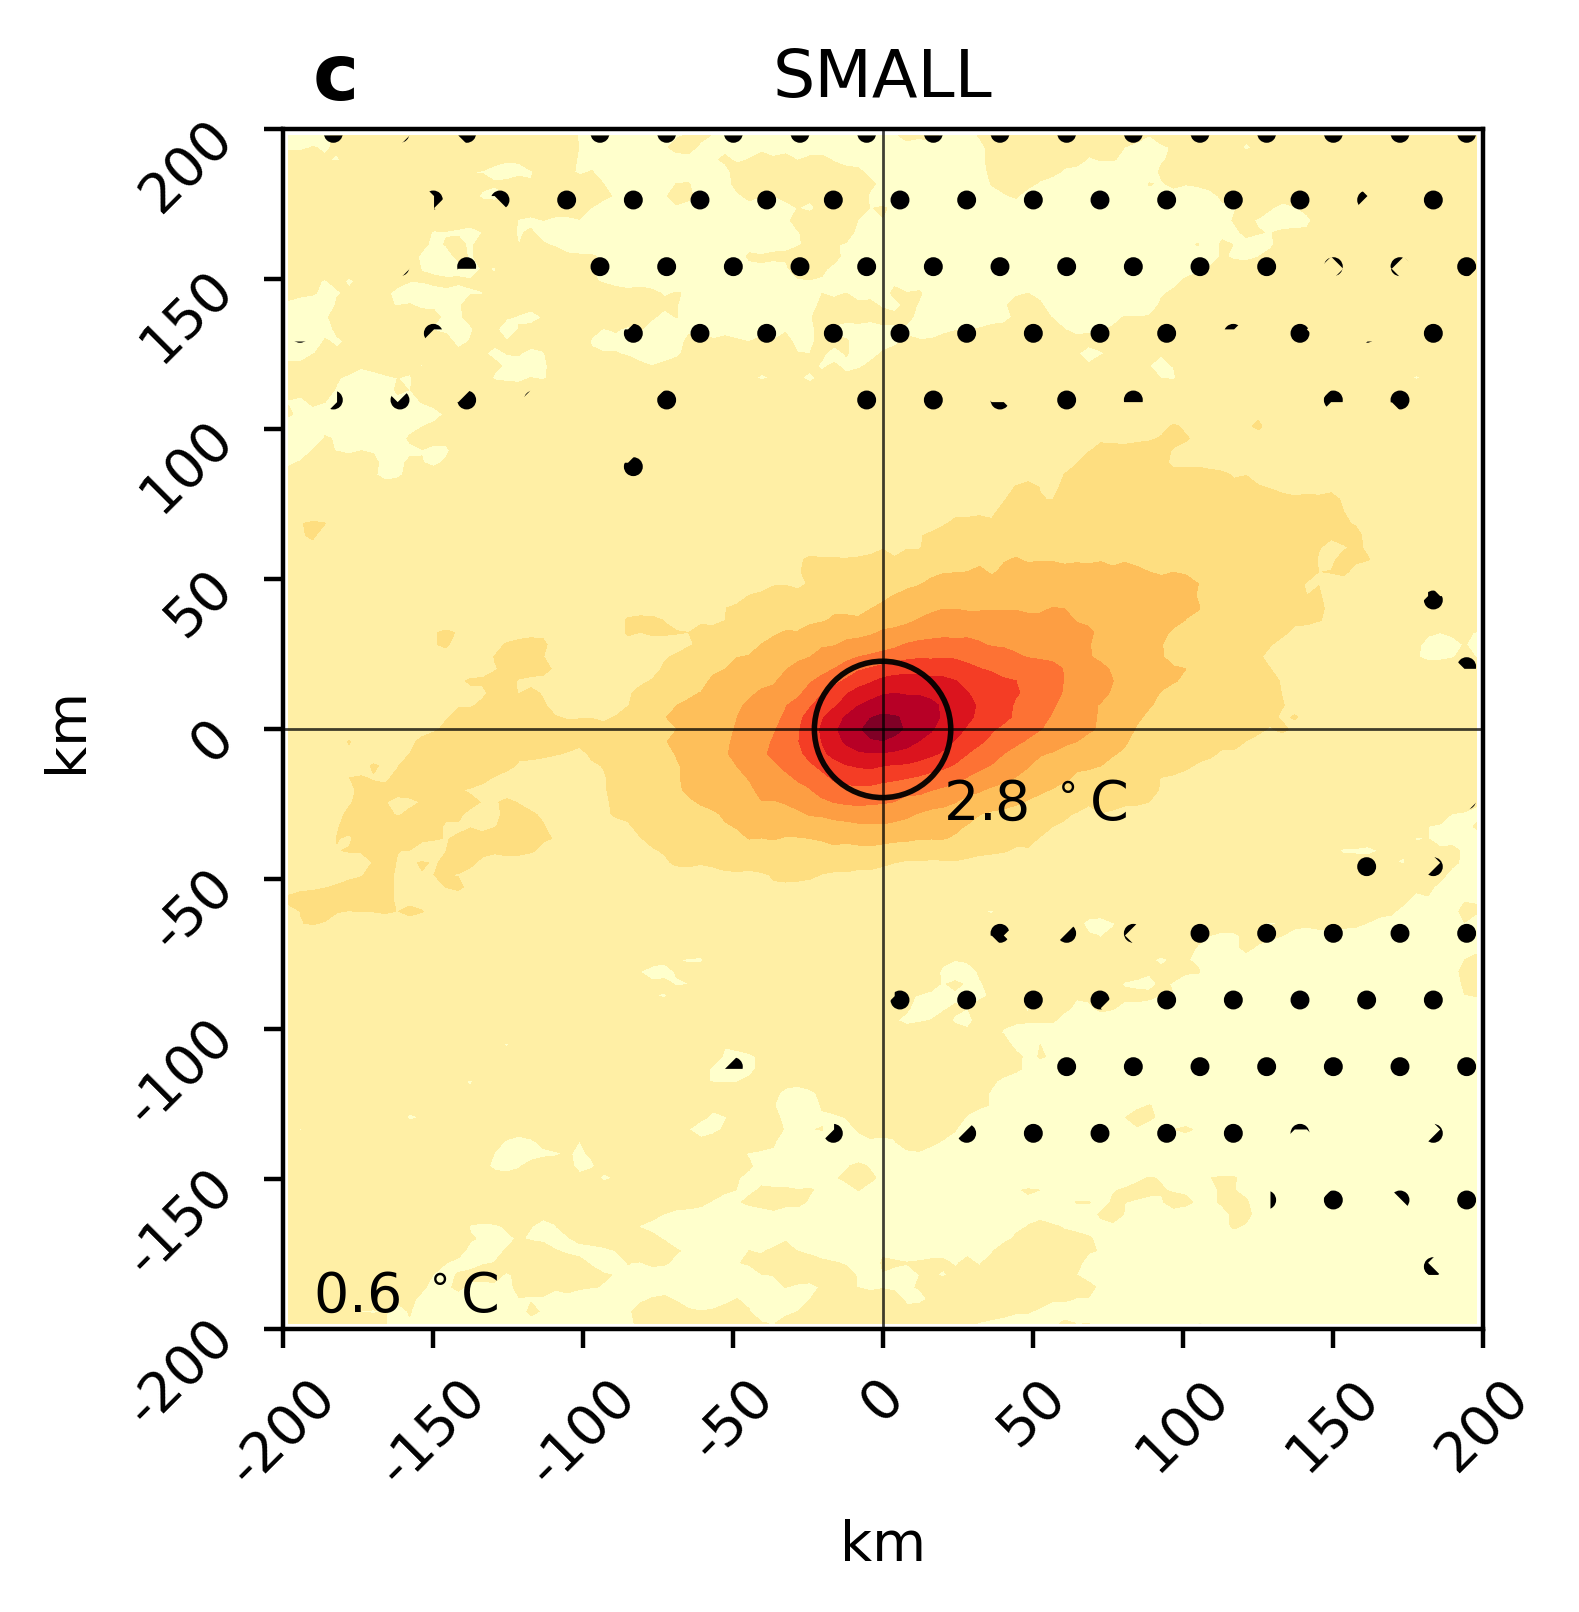

In [13]:
#~ Plot

lprop = {'small': ['-', 'b'], 'large': ['--', 'g']}

circle_ano = Circle((xs[int(len(xs)/2)], ys[int(len(ys)/2)]), r, facecolor='none', edgecolor='k', linewidth=1, linestyle='-', alpha=0.95)

if var == 'q2':
    rounder = 5
else:
    rounder = 1

xtlbs = np.arange(-200, 200+50, 50)
xtcks = xtlbs / res
ytlbs = np.arange(-200, 200+50, 50)
ytcks = ytlbs / res

anomin = anolims_SM_contrast[var][0]
anomax = anolims_SM_contrast[var][1]

if var == 'twb':
    cmap_ano = 'YlOrRd'
    cmap = plt.get_cmap(cmap_ano)
    bounds = np.linspace(anomin, anomax, 11)
    norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)
elif var == 'lsRain':
    cmap_ano = 'RdBu'
    cmap = plt.get_cmap(cmap_ano)
    bounds = np.linspace(anomin, anomax, 11)
    norm = MidpointNormalize(vmin=anomin, vmax=anomax, midpoint=0)
else:
    cmap_ano = cmaps['ano']
    cmap = plt.get_cmap(cmap_ano)
    bounds = np.linspace(anomin, anomax, 11)
    norm = MidpointNormalize(vmin=anomin, vmax=anomax, midpoint=0)

fig_ano, ax_ano = plt.subplots(ncols=1, dpi=400)

plt.subplots_adjust(left=0.15, right=0.9, bottom=0.15, top=0.9)

ax_ano.contourf(xs, ys, var_hhee_ano_2plot, levels=bounds, norm=norm, cmap=cmap)

ax_ano.contourf(xs, ys, pvalues_, hatches=['.'], colors='none')

ax_ano.text(0.025, 1.025, flabel, weight="bold", fontsize=14, transform=ax_ano.transAxes)
ax_ano.text(0.55, 0.425, '{0} {1}'.format(str(round(vals_ano_disc_mean, rounder)), unit), transform=ax_ano.transAxes)
ax_ano.text(0.025, 0.015, '{0} {1}'.format(str(round(varanomean, rounder)), unit), transform=ax_ano.transAxes)

ax_ano.add_patch(circle_ano)

ax_ano.axhline(yc, 0, 1, color='k', alpha=0.75, lw=0.5)
ax_ano.axvline(xc, 0, 1, color='k', alpha=0.75, lw=0.5)

ax_ano.set_title('%s'%size.upper())   #  (%i km), size_length
ax_ano.set_aspect('equal')
ax_ano.set_xlabel('km')
ax_ano.set_ylabel('km')
ax_ano.set_xticks(xtcks)
ax_ano.set_xticklabels(xtlbs, rotation=45)
ax_ano.set_yticks(ytcks)
ax_ano.set_yticklabels(ytlbs, rotation=45)

fig_ano.set_size_inches(4., 4.)

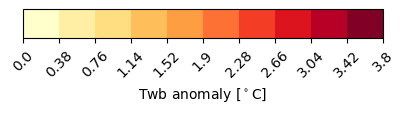

In [14]:
fig_cb_ano, ax_cb_ano = plt.subplots(figsize=(4.5, 1.15))

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.65, top=0.9)

if var == 'q2':
    cbtks = bounds
    cblbs = [str(round(b*1000, 2)) for b in bounds]
    cb_unit = 'g kg$^{-1}$'
else:
    cbtks = bounds
    cblbs = [str(round(b,2)) for b in bounds]
    cb_unit = unit

cb_ano = fig_cb_ano.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_cb_ano, orientation='horizontal', label='%s anomaly [%s]'% (var_, cb_unit), shrink=0.95, pad=0.15)
cb_ano.set_ticks(cbtks)
cb_ano.set_ticklabels(cblbs)
cb_ano.ax.tick_params(labelrotation=45.)